In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os

In [2]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 11))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

def get_rgb_image(path: str) -> np.array:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

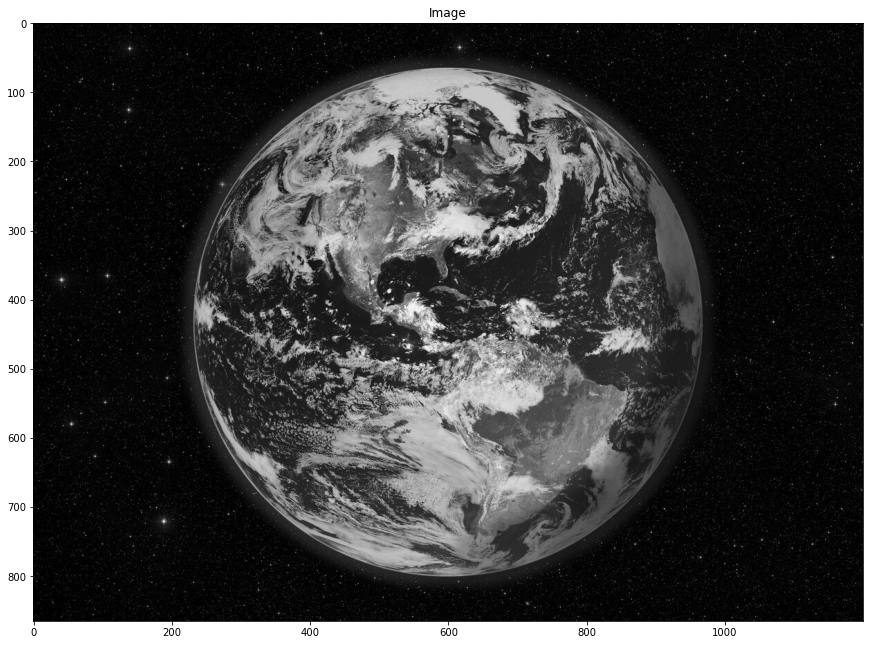

In [3]:
image = cv2.imread(r'earth.jpg',  cv2.IMREAD_GRAYSCALE)
visualize(image=image)

(0.0, 100000.0)

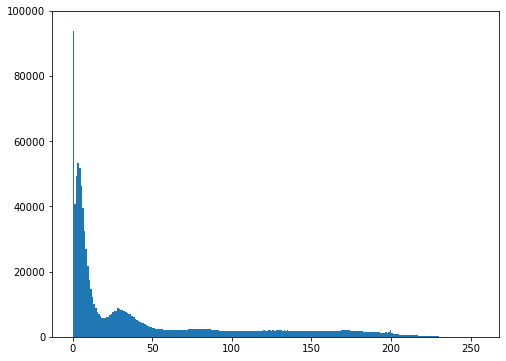

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(np.resize(image, -1), bins=256);
plt.ylim(0, 100000)

---
---
## Свертка
---
---

In [5]:
def convolve2D(image, kernel, padding=None, strides=1):
    kernel = np.flipud(np.fliplr(kernel))
    xKernShape = kernel.shape[0]
    
    if padding is None:
        padding = len(kernel) // 2
        
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]
    
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    
    output = np.zeros((xOutput, yOutput))
    
    imagePadded = np.zeros((image.shape[0] + padding * 2, image.shape[1] + padding * 2))
    if padding == 0:
        imagePadded[:, :] = image[:, :]
    else:
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    
    for y in range(image.shape[1]):
        
        if y > image.shape[1] - yKernShape:
            break
            
        if y % strides == 0:
            for x in range(image.shape[0]):
                
                if x > image.shape[0] - xKernShape:
                    break
                    
                try:
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

---
---
## Метод простого градиента
---
---

In [6]:
grad1 = np.array([[-1, 1]]).T
grad2 = np.array([[-1, 1]])
print('Ядро 1: \n' + str(grad1) + '\n' + 'Ядро 2: \n' + str(grad2))

Ядро 1: 
[[-1]
 [ 1]]
Ядро 2: 
[[-1  1]]


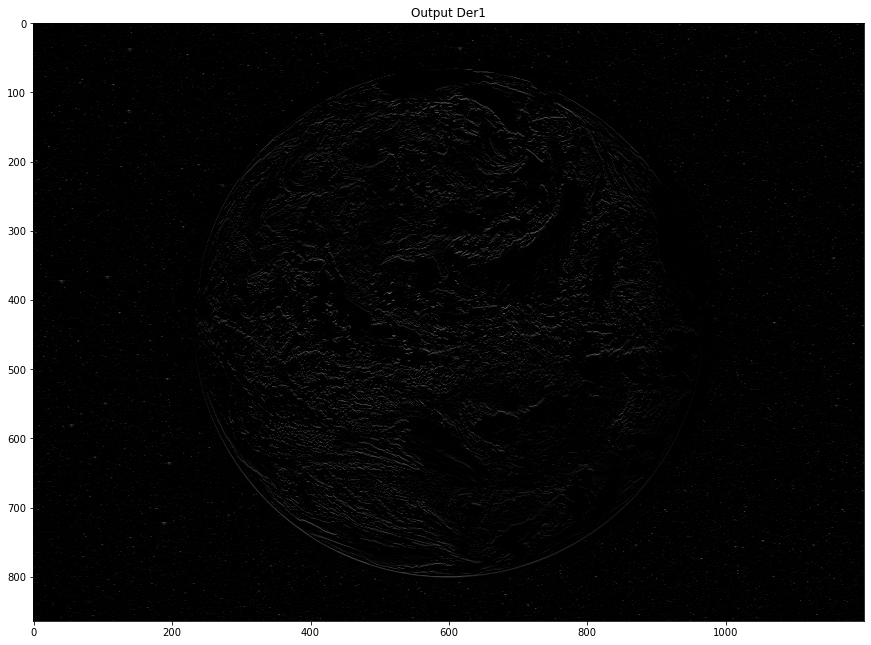

In [7]:
kernel = grad1

output_der1 = convolve2D(image, kernel, padding=0)
visualize(output_der1=output_der1)

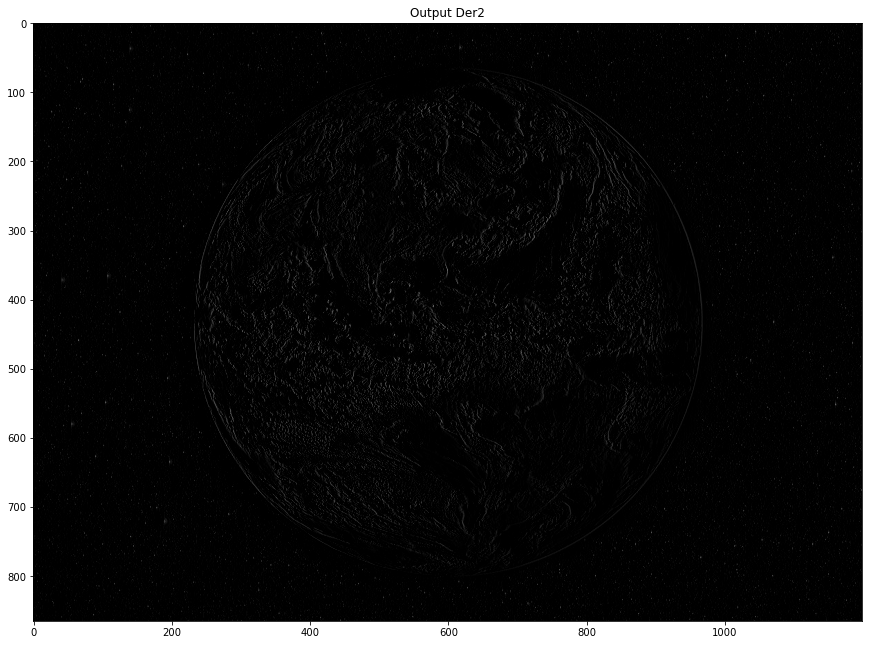

In [8]:
kernel = grad2

output_der2 = convolve2D(image, kernel, padding=0)
visualize(output_der2=output_der2)

In [9]:
output_der1 = np.vstack((output_der1, np.zeros(output_der1.shape[1])))
output_der2 = np.vstack((output_der2.T, np.zeros(output_der2.shape[0]))).T

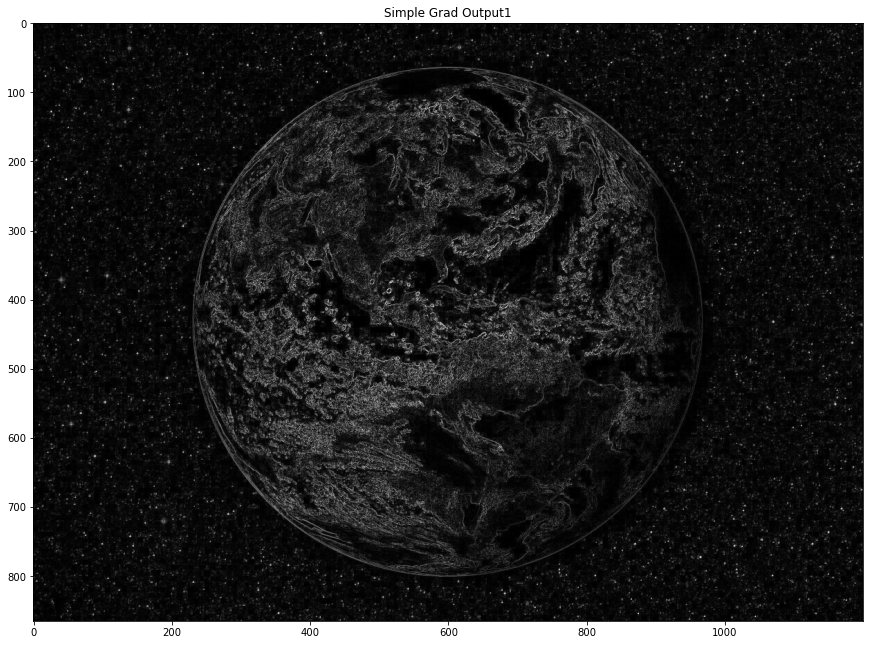

In [10]:
simple_grad_output1 = np.abs(output_der1) + np.abs(output_der2)
visualize(simple_grad_output1=simple_grad_output1)

(0.0, 100000.0)

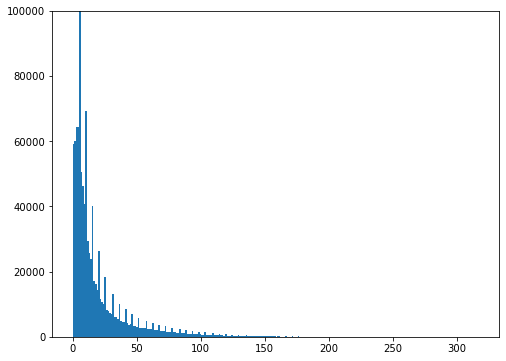

In [30]:
plt.figure(figsize=(8, 6))
plt.hist(np.resize(simple_grad_output1, -1), bins=256);
plt.ylim(0, 100000)

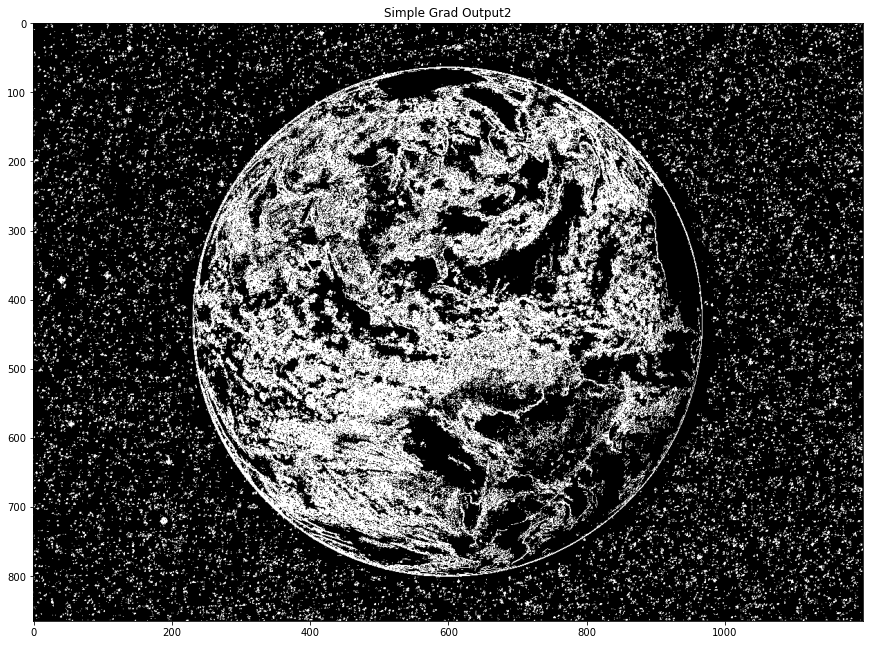

In [12]:
simple_grad_output2 = np.where(simple_grad_output1 >= 25, 255, 0)
visualize(simple_grad_output2=simple_grad_output2)

---
---
## Метод простого градиента с заменой модуля градиента на сумму квадратов производных
---
---

In [13]:
output_der1 = convolve2D(image, grad1, padding=0)
output_der2 = convolve2D(image, grad2, padding=0)

# Квадраты производных
abs_der1 = output_der1**2
abs_der2 = output_der2**2

abs_der1 = np.vstack((abs_der1, np.zeros(abs_der1.shape[1])))
abs_der2 = np.vstack((abs_der2.T, np.zeros(abs_der2.shape[0]))).T

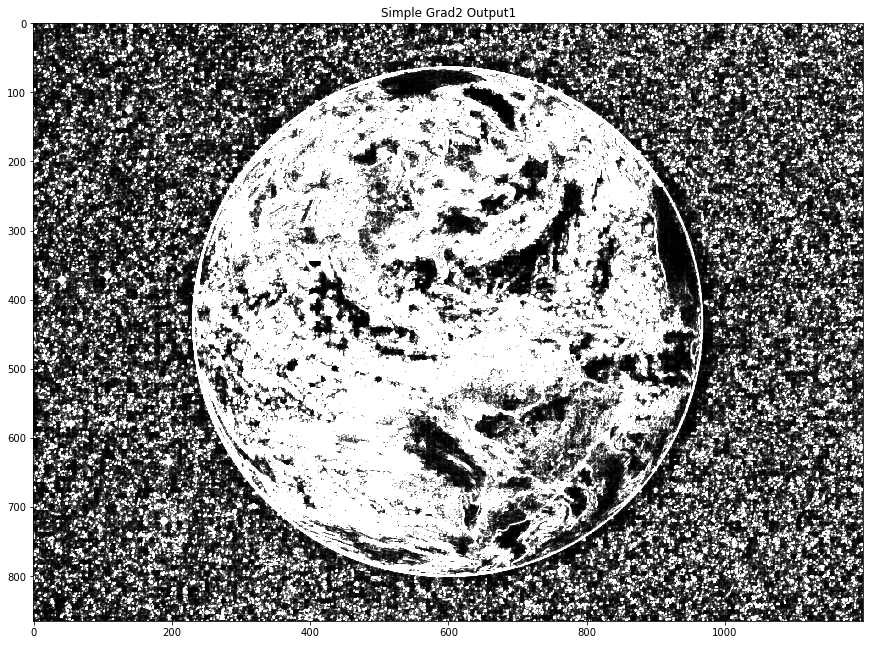

In [14]:
simple_grad2_output1 = abs_der1 + abs_der2

visualize(simple_grad2_output1=simple_grad2_output1)

(0.0, 100000.0)

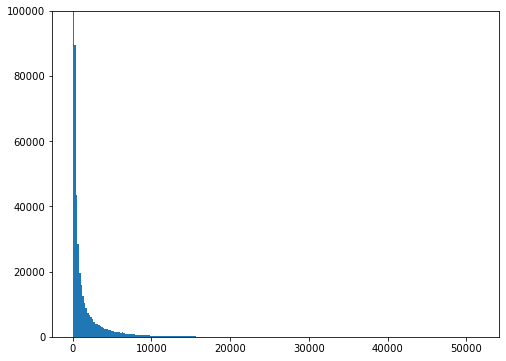

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(np.resize(simple_grad2_output1, -1), bins=256);
plt.ylim(0, 100000)

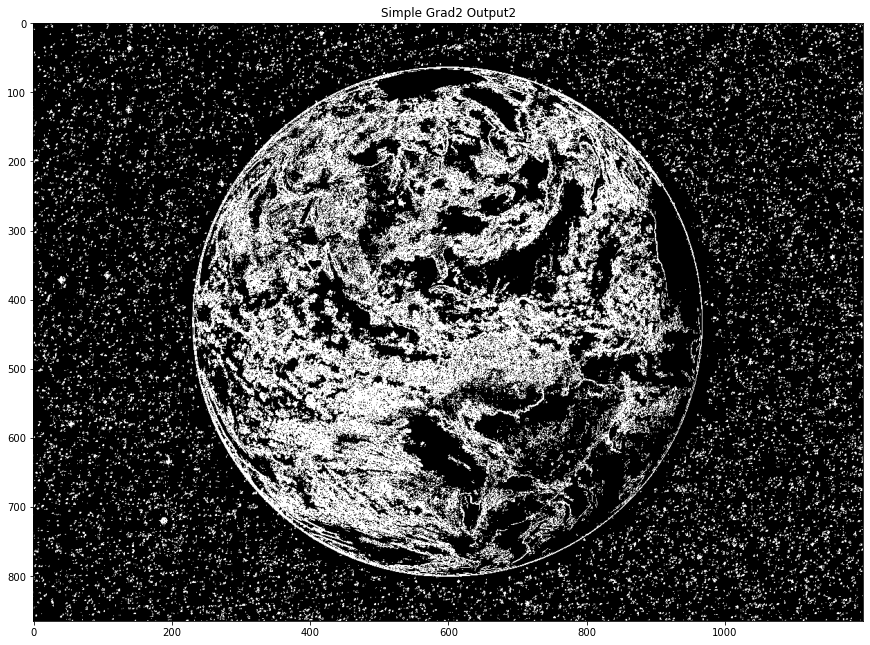

In [20]:
simple_grad2_output2 = np.where(simple_grad2_output1 >= 400, 255, 0)

visualize(simple_grad2_output2=simple_grad2_output2)

---
---
## Дифференциальный метод 2-го порядка. Аппроксимация поверхностью 2-го порядка, окно 5x5
---
---

In [21]:
from sympy.abc import a, b, c, alpha, beta, gamma
import sympy

In [22]:
def create_mask(mask_size, f_cap, function_parameters):
    """
    Данная функция генерирует маски, которые необходимы для расчета
    коэффициентов аппроксимирующей поверхности.
    Размер маски должен быть нечетным.
    В качестве параметра f_cap нужно передать название ранее объявленной
    функции, которая задает аппроксимирующую поверхность.
    В качестве параметра function_parameters необходимо передавать массив символьных
    коэффициентов (предварительно импортированных из пакета sympy.abc), которые используются
    в функции, переданной в качестве параметра f_cap.
    :param mask_size: размер маски
    :param f_cap: функция, задающая аппроксимирующую поверхность (f_cap == f с крышечкой)
    :param function_parameters: параметры функции f_cap (массив символьных коэффициентов,
            которые являются коэффициентами уравнения аппроксимирующей поверхности)
    :return: словарь с масками. Ключами словаря являются символы, переданные в массиве function_parameters,
            значениями словаря являются маски, с помощью которых вычисляется тот или иной параметр
    """
    # символьная функция f (физический смысл - исходная функция яркости)
    # здесь мы будем работать именно с символьной функцией, потому что нам требуется вычислить 
    # коэффиценты маски, a через данную функцию будут выражены параметры аппроксимирующей поверхности
    # например, a = f(0,0) + f(1,1)
    # !!! сами значения исходной функции яркости для вычисления маски не нужны !!!
    f = sympy.Function('f')
    
    # вычисляем квадрат ошибки по формуле из методички
    # PS за элемент маски с координатами (0, 0) будем считать левый верхний элемент
    e = sympy.Float(0)
    for i in range(mask_size):
        for j in range(mask_size):
            e = e + (f_cap(i, j) - f(i, j)) ** 2

    # формируем массив из первых производных выражения для e по каждому из параметров
    # если у нас 3 параметра a,b,c, то diff = [de/da, de/db, de/dc]
    diff = [e.diff(p, 1) for p in function_parameters]

    # решаем систему линейных уравнений (каждое уравнение
    # представляет собой производную по какому-либо параметру,
    # приравненную к 0, например de/da = 0)
    # второй параметр функции solve определяет набор переменных,
    # значение которых мы хотим получить после решения системы уравнений
    cf = sympy.solve(diff, function_parameters)
    
    # формируем словарь, ключом которого является символьный параметр,
    # маски пока что заполняем нулями
    mask = {p: np.zeros(shape=(mask_size, mask_size)) for p in function_parameters}
    
    # для каждого параметра
    for p in function_parameters:
        # вычисляем маску следующим образом:
        # значением элемента маски с индексом (i, j) будет
        # коэффициент перед f(i,j) в выражении, полученном после решения системы уравнений
        # например для маски 2х2, если а = 2*f(0, 0) + 3*f(1, 0) + 5*f(0, 1), 
        # то маска будет такой: 
        # [[2,5],
        #  [3, 0]]
        for i in range(mask_size):
            for j in range(mask_size):
                mask[p][i, j] = cf[p].coeff(f(i, j))
    return mask

In [23]:
def F2(x1, x2):
    """ Поверхность второго порядка
    """
    return a * x1**2 + b * x2**2 + c * x1 * x2 + alpha * x1 + beta * x2 + gamma

In [24]:
M = create_mask(5, F2, [a, b, c, alpha, beta, gamma])
kernel = 2*M[a] + 2*M[b]

print(kernel)

[[ 0.11428571  0.02857143  0.          0.02857143  0.11428571]
 [ 0.02857143 -0.05714286 -0.08571429 -0.05714286  0.02857143]
 [ 0.         -0.08571429 -0.11428571 -0.08571429  0.        ]
 [ 0.02857143 -0.05714286 -0.08571429 -0.05714286  0.02857143]
 [ 0.11428571  0.02857143  0.          0.02857143  0.11428571]]


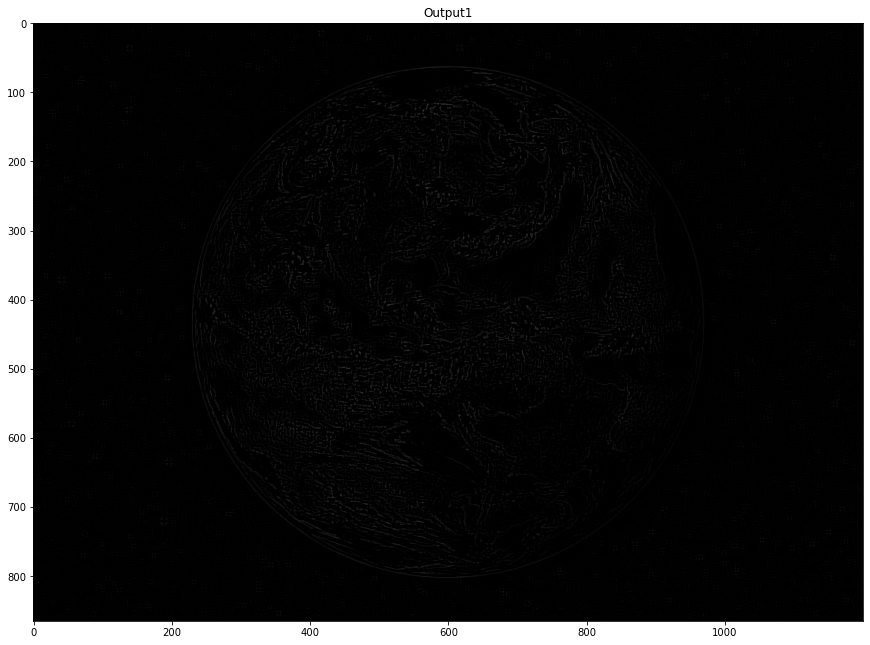

In [25]:
output1 = convolve2D(image, kernel, padding=2)
visualize(output1=output1)

(0.0, 100000.0)

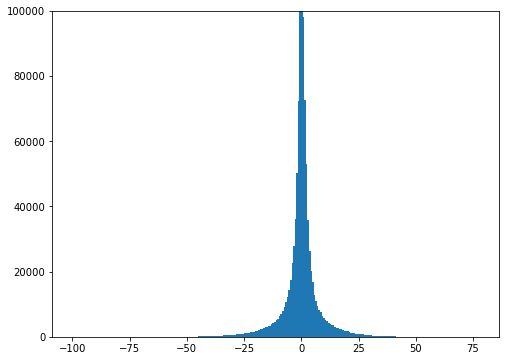

In [32]:
plt.figure(figsize=(8, 6))
plt.hist(np.resize(output1, -1), bins=256);
plt.ylim(0, 100000)

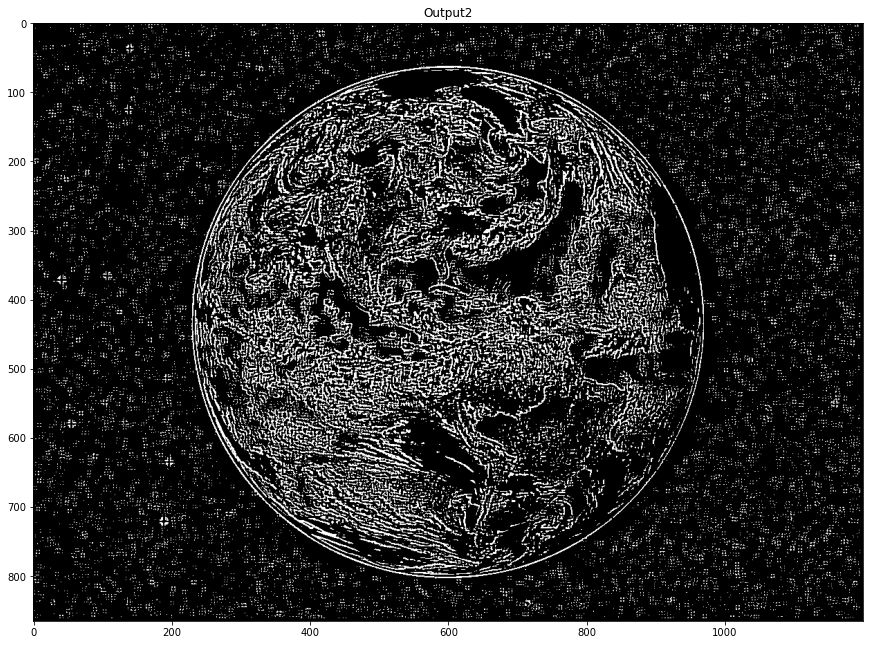

In [42]:
output2 = np.where(output1 >= 5, 255, 0)
visualize(output2=output2)